In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Miscelanous plots

In [3]:
t1data = Table.read('../combined/trappist-1_sed_var_res_v03.ecsv')
w, f = t1data['WAVELENGTH'], t1data['FLUX']

In [4]:
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100

Scaled to bolometric flux

1.1800458785565196e+16 k4 pc2 / K4


/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


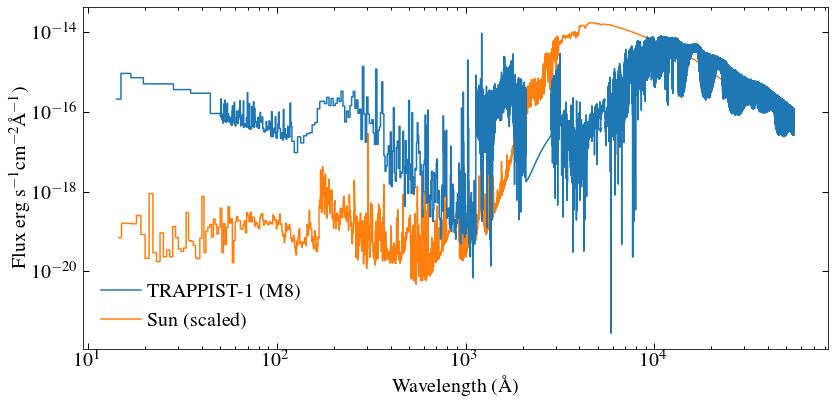

In [19]:
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = (u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2
print(bb_scale)

plt.figure(figsize=(12,6))
plt.step(w[f>0], f[f>0],label ='TRAPPIST-1 (M8)', where='mid')
plt.step(w_sol[w_sol>w[0]], f_sol[w_sol>w[0]]/bb_scale, zorder=-1, label = 'Sun (scaled)' , where='mid')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(100, 1000)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/Trappist1_GJ674_bb_scaled.pdf', dpi=150)
#plt.savefig('../plots/Trappist1_GJ674_bb_scaled.png', dpi=150)
#plt.savefig('../plots/Trappist1_solar_euv_scaled.png', dpi=150)


Hmm, very messy - better to do it with sep model? Or smooth the COS bits

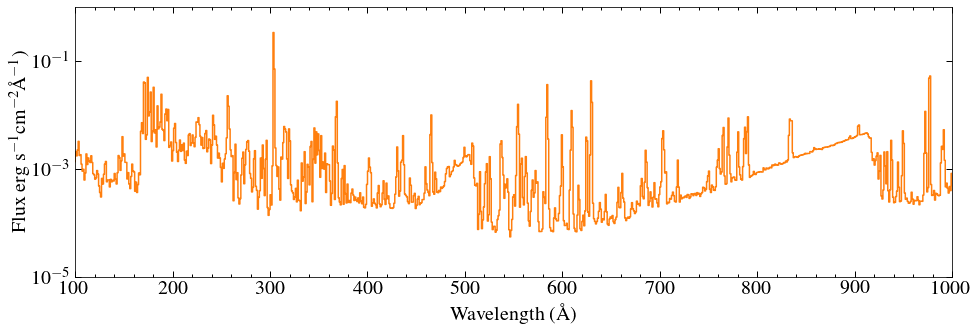

In [14]:
plt.step(w_sol, f_sol, zorder=-1, label = 'Sun (scaled)' , where='mid', c='C1')
plt.xlim(100, 1000)
plt.ylim(1e-5, 1)
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
plt.savefig('sun_euv.png', dpi=100)
